In [17]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib notebook

import numpy as np 

import os 

matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/data_cleaned_newfilt_subj_01k101k1.mat'


In [2]:
filecontents = sio.whosmat(matfile)
print(filecontents)

filecontents[0][0]

[('data_cleaned_newfilt_subj_01k1', (1, 1), 'struct')]


'data_cleaned_newfilt_subj_01k1'

In [3]:
import mne
import numpy as np
import scipy.io as sio
 
def loadftfile(path):

    filecontents = sio.whosmat(matfile)
    
    strucname = filecontents[0][0]

    mat = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    matstruct = mat[strucname]
    return matstruct 

In [4]:
def importmatfile(ftdata):
# ftdata has to be a fieldtrip structure 
    
    ch_name = [l for l in ftdata.hdr.label]
    #print(ch_name)
    #ch_all = [l.encode('ascii') for l in data.elec.label]
    ch_type = ftdata.label
    ch_type[:] = 'eeg'
    sfreq = ftdata.fsample
    
    #sel=np.ones(len(data.elec.chanpos)).astype(int)

    #montage=mne.channels.Montage(pos=data.elec.chanpos,
    #                             ch_names=ch_all,
    #                             kind='BrainGraph',selection=sel)
    
    # Initialize an info structure
    #info = mne.create_info(ch_names=ch_name,ch_types=ch_type,sfreq=sfreq,montage=montage)
    info = mne.create_info(ch_names=ch_name,ch_types=ch_type,sfreq=sfreq)
    
    ###############################################################################
    # It is necessary to supply an "events" array in order to create an Epochs
    # object. This is of `shape(n_events, 3)` where the first column is the sample
    # number (time) of the event, the second column indicates the value from which
    # the transition is made from (only used when the new value is bigger than the
    # old one), and the third column is the new event value.
    
    # Create an event matrix: 10 events with alternating event codes
    
    events=np.zeros((len(np.array(ftdata.trialinfo)),3),dtype=int)
    events[:,0]=ftdata.sampleinfo[:,0]
    events[:,2]=ftdata.trialinfo
    
    #events[:,2]=data.trialinfo[:,path['event']]
    # More information about the event codes:
    #event_id = event
    ###############################################################################
    # Finally, we must specify the beginning of an epoch (the end will be inferred
    # from the sampling frequency and n_samples)
    tmin=ftdata.time[0][0]
    
    alldata = []
    for curdata in ftdata.trial:
        alldata.append(curdata)
    
    dat = np.stack(alldata)
    ###############################################################################
    # Now we can create the :class:`mne.EpochsArray` object
    
    #custom_epochs = mne.EpochsArray(dat, info, tmin=tmin)
    
    return dat,info,events,tmin

###############################################################################
###############################################################################

In [5]:
def matstruct2mneEpochsArray(matstruct):
    dat1,info,events_iso_std,tmin = importmatfile(matstruct.iso.standard)
    dat2,_,events_iso_dev,_ = importmatfile(matstruct.iso.deviant)
    dat3,_,events_rnd_std,_ = importmatfile(matstruct.rnd.standard)
    dat4,_,events_rnd_dev,_ = importmatfile(matstruct.rnd.deviant)

    alldata = np.vstack([dat1,dat2,dat3,dat4])

    allevents = np.vstack([events_iso_std,events_iso_dev,events_rnd_std,events_rnd_dev])

    indexsorted = np.argsort(allevents,axis=0)

    allevents_sorted = allevents[indexsorted[:,0]]
    alldata_sorted  = alldata[indexsorted[:,0]]                        

    events_id = dict(iso_std = events_iso_std[0,2],
                     iso_dev=events_iso_dev[0,2],
                     rnd_std=events_rnd_std[0,2],
                     rnd_dev=events_rnd_dev[0,2])


    return mne.EpochsArray(alldata_sorted,info,tmin=tmin,events=allevents_sorted,event_id=events_id)


In [6]:
def import2mne(matfile):
    #first open the matfile 
    matstruct = loadftfile(matfile)
    
    #then open each condition
    
    return matstruct2mneEpochsArray(matstruct)

In [7]:
mneEpochs = import2mne(matfile)

657 matching events found
0 projection items activated
0 bad epochs dropped


In [15]:
evoked = mneEpochs.average()

<IPython.core.display.Javascript object>


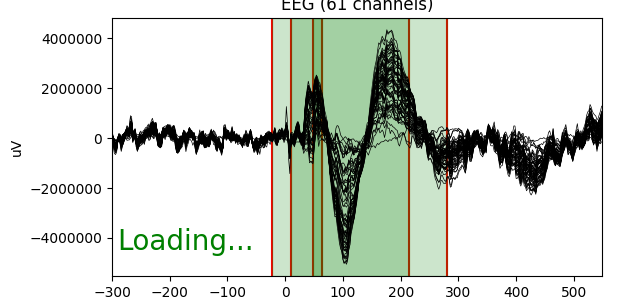

In [19]:
evoked.plot()
plt.show()